In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [3]:
# 一些超参数
learning_rate = 1e-3
eval_iters = 10
batch_size=1000
sequence_len=64
# 如果有GPU，该脚本将使用GPU进行计算
device = 'cuda' if torch.cuda.is_available() else 'cpu'

感谢Wanghaha（xufengnian-bei）的贡献，如果在下载过程中遇到网络问题，请使用下面的步骤进行处理。

* 访问 Hugging Face 数据集页面: https://huggingface.co/datasets/code_search_net
* 在页面上找到 "Files and versions" 部分。
* 点击data文件夹，下载对应的python.zip

修改对应下载文件代码：

datasets = load_dataset('json', data_files='data/python/python/final/jsonl/train/*.jsonl.gz') # 更换为自己的目录
datasets = datasets['train'].filter(lambda x: 'apache/spark' in x['repo']) # 这里repository_name 更换为 repo

print(datasets[8]['original_string']) # whole_func_string 更换为 original_string

In [4]:
raw_datasets = load_dataset("code_search_net", "python")
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repository_name'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code_search_net.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

Filter:   0%|          | 0/412178 [00:00<?, ? examples/s]

In [5]:
class CharTokenizer:

    def __init__(self, data, end_ind=0):
        # data: list[str]
        # 得到所有的字符
        chars = sorted(list(set(''.join(data))))
        self.char2ind = {s: i + 1 for i, s in enumerate(chars)}
        self.char2ind['<|e|>'] = end_ind
        self.ind2char = {v: k for k, v in self.char2ind.items()}
        self.end_ind = end_ind

    def encode(self, x):
        # x: str
        return [self.char2ind[i] for i in x]

    def decode(self, x):
        # x: int or list[x]
        if isinstance(x, int):
            return self.ind2char[x]
        return [self.ind2char[i] for i in x]

tokenizer = CharTokenizer(datasets['whole_func_string'])
test_str = 'def f(x):'
re = tokenizer.encode(test_str)
print(re)
''.join(tokenizer.decode(range(len(tokenizer.char2ind))))

[70, 71, 72, 2, 72, 10, 90, 11, 28]


'<|e|>\n !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~ö'

In [6]:
def process(data, tokenizer, sequence_len=sequence_len):
    text = data['whole_func_string']
    # text is list[str]
    inputs, labels = [], []
    for t in text:
        enc = tokenizer.encode(t)
        enc += [tokenizer.end_ind]
        # 有bug，无法处理长度过小的数据
        for i in range(len(enc) - sequence_len):
            inputs.append(enc[i: i + sequence_len])
            labels.append(enc[i + 1: i + 1 + sequence_len])
    return {'inputs': inputs, 'labels': labels}

# 将数据分为训练集和测试集
tokenized = datasets.train_test_split(test_size=0.1, seed=1024, shuffle=True)

f = lambda x: process(x, tokenizer)
tokenized = tokenized.map(f, batched=True, remove_columns=datasets.column_names)
tokenized.set_format(type='torch', device=device)

tokenized['train']['inputs'].shape, tokenized['train']['labels'].shape

Map:   0%|          | 0/617 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

(torch.Size([605913, 64]), torch.Size([605913, 64]))

In [7]:
train_loader = DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tokenized['test'], batch_size=batch_size, shuffle=True)
next(iter(train_loader))

{'inputs': tensor([[ 2, 84, 67,  ...,  2, 86, 91],
         [69, 74, 71,  ...,  2,  2,  2],
         [71,  2, 12,  ..., 85, 71, 78],
         ...,
         [ 2,  2,  2,  ..., 71, 16,  1],
         [67, 79, 71,  ...,  2, 84, 71],
         [ 2,  2,  2,  ..., 79,  2, 71]], device='cuda:0'),
 'labels': tensor([[84, 67, 75,  ..., 86, 91, 82],
         [74, 71, 16,  ...,  2,  2,  2],
         [ 2, 12, 71,  ..., 71, 78, 91],
         ...,
         [ 2,  2,  2,  ..., 16,  1,  1],
         [79, 71,  2,  ..., 84, 71, 85],
         [ 2,  2,  2,  ...,  2, 71, 80]], device='cuda:0')}

In [8]:
@torch.no_grad()
def generate(model, context, tokenizer, max_new_tokens=300):
    # context: (1, T)
    #out = []
    out = context.tolist()[0]
    model.eval()
    for _ in range(max_new_tokens):
        #可以考虑截断背景，使得文本生成更加贴近训练
        #logits = model(context[:, -sequence_len:])
        logits = model(context)            # (1, T, 98)
        probs = F.softmax(logits[:, -1, :], dim=-1)  # (1, 98)
        # 随机生成文本
        ix = torch.multinomial(probs, num_samples=1)  # (1, 1)
        # 更新背景
        context = torch.concat((context, ix), dim=-1)
        out.append(ix.item())
        if out[-1] == tokenizer.end_ind:
            break
    model.train()
    return out

In [9]:
def estimate_loss(model):
    re = {}
    # 将模型切换至评估模式
    model.eval()
    re['train'] = _loss(model, train_loader)
    re['test'] = _loss(model, test_loader)
    # 将模型切换至训练模式
    model.train()
    return re

@torch.no_grad()
def _loss(model, data_loader):
    """
    计算模型在不同数据集下面的评估指标
    """
    loss = []
    data_iter= iter(data_loader)
    # 随机使用多个批量数据来预估模型效果
    for k in range(eval_iters):
        data = next(data_iter, None)
        if data is None:
            data_iter = iter(data_loader)
            data = next(data_iter, None)
        inputs, labels = data['inputs'], data['labels']  # (B, T)
        logits = model(inputs)                           # (B, T, vs)
        # 请参考官方文档
        loss.append(F.cross_entropy(logits.transpose(-2, -1), labels).item())
    return torch.tensor(loss).mean().item()

In [10]:
def train_model(model, optimizer, epochs=10):
    # 记录模型在训练集上的模型损失
    lossi = []
    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['inputs'], data['labels']  # (B, T)
            optimizer.zero_grad()
            logits = model(inputs)                           # (B, T, vs)
            loss = F.cross_entropy(logits.transpose(-2, -1), labels)
            lossi.append(loss.item())
            loss.backward()
            optimizer.step()
        # 评估模型，并输出结果
        stats = estimate_loss(model)
        train_loss = f'train loss {stats["train"]:.4f}'
        test_loss = f'test loss {stats["test"]:.4f}'
        print(f'epoch {epoch:>2}: {train_loss}, {test_loss}')
    return lossi

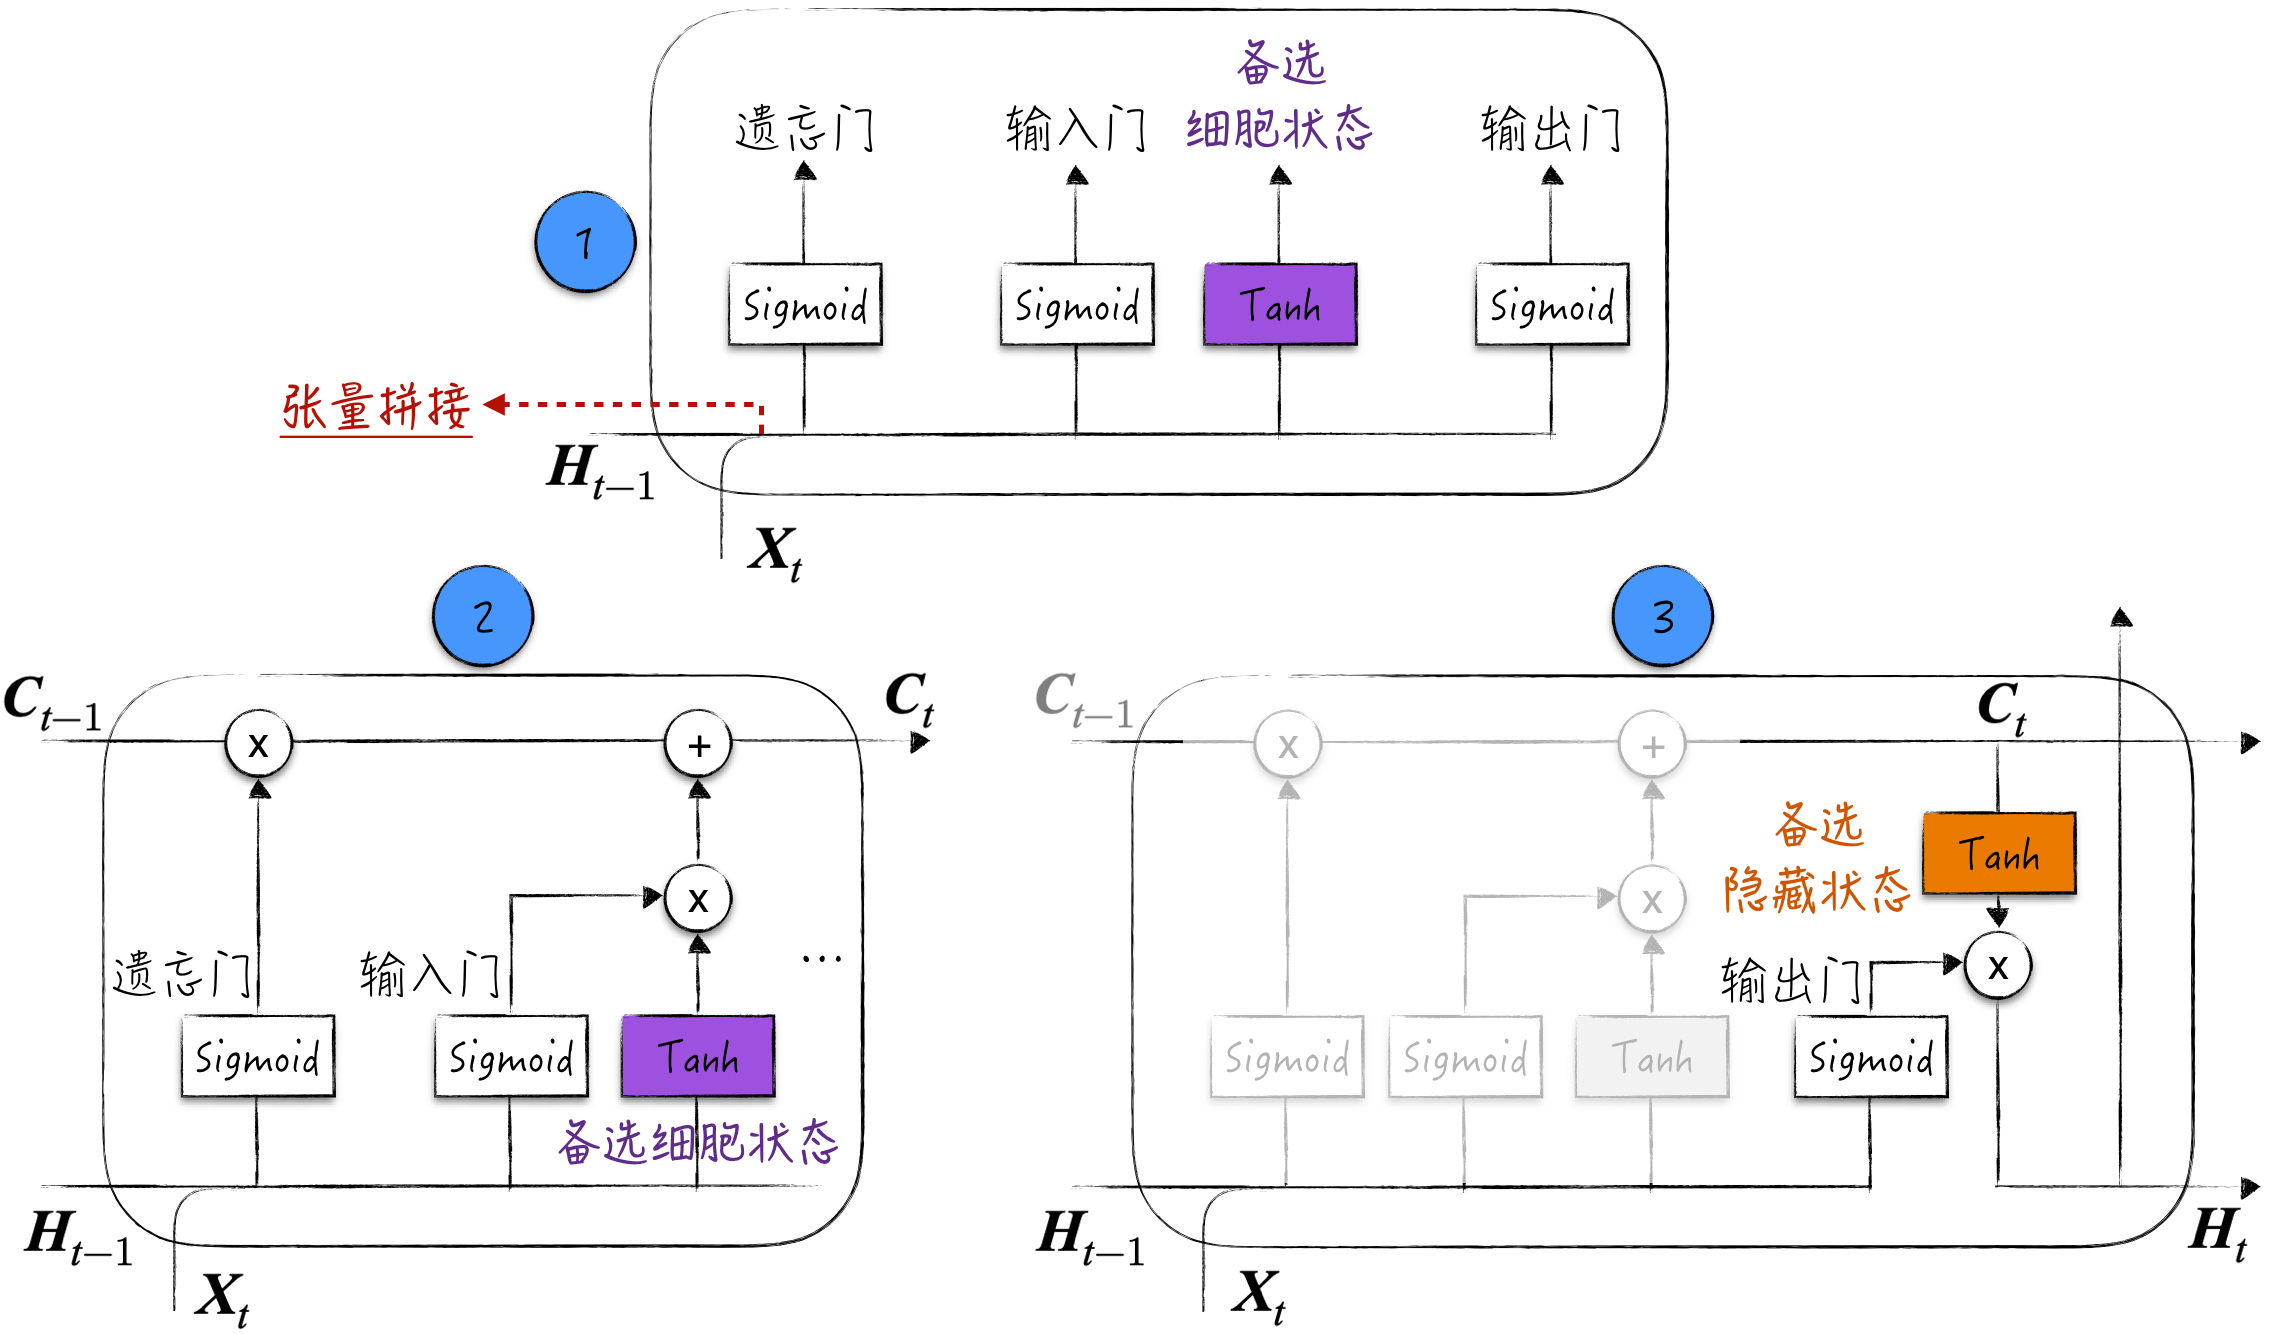

In [14]:
class LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        combined_size = hidden_size + input_size
        self.forget_gate = nn.Linear(combined_size, hidden_size)     # 遗忘门
        self.in_gate = nn.Linear(combined_size, hidden_size)         # 输入门
        self.new_cell_state = nn.Linear(combined_size, hidden_size)  # 备选细胞状态
        self.out_gate = nn.Linear(combined_size, hidden_size)        # 输出门

    def forward(self, input, state=None):
        # input: (B, I)
        # state: ((B, H), (B, H))
        B = input.shape[0]
        if state is None:
            state = self.init_state(B, input.device)
        hs, cs = state
        combined = torch.concat((input, hs), dim=-1)   # (B, I + H)
        # 细胞状态的更新
        ingate = F.sigmoid(self.in_gate(combined))
        forgetgate = F.sigmoid(self.forget_gate(combined))
        ncs = F.tanh(self.new_cell_state(combined))
        cs = (cs * forgetgate) + (ingate * ncs)
        # 隐藏状态的更新
        outgate = F.sigmoid(self.out_gate(combined))
        hs = F.tanh(cs) * outgate
        return hs, cs

    def init_state(self, B, device):
        hs = torch.zeros((B, self.hidden_size), device=device)
        cs = torch.zeros((B, self.hidden_size), device=device)
        return hs, cs

In [15]:
l_cell = LSTMCell(3, 4)
x = torch.randn(5, 3)
a, b = l_cell(x)
a.shape, b.shape

(torch.Size([5, 4]), torch.Size([5, 4]))

In [16]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.cell = LSTMCell(input_size, hidden_size)

    def forward(self, input, state=None):
        # input:  (B, T, C)
        # state:  ((B, H), (B, H))
        # out:    (B, T, H)
        B, T, C = input.shape
        re = []
        for i in range(T):
            state = self.cell(input[:, i, :], state)
            re.append(state[0])
        return torch.stack(re, dim=1)                                  # (B, T, H)


In [18]:
def test_lstm():
    '''
    测试LSTM实现的准确性
    '''
    # 随机生成模型结构
    B, T, input_size, hidden_size, num_layers = torch.randint(1, 20, (5,)).tolist()
    ref_model = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
    # 随机生成输入
    inputs = torch.randn(B, T, input_size)
    hs, cs = torch.randn((2 * num_layers, B, hidden_size)).chunk(2, 0)
    re = inputs
    # 取出模型参数
    for layer_index in range(num_layers):
        l = ref_model.all_weights[layer_index]
        if layer_index == 0:
            model = LSTM(input_size, hidden_size)
        else:
            model = LSTM(hidden_size, hidden_size)
        i, f, c, o = torch.cat((l[0], l[1]), dim=1).chunk(4, 0)
        ib, fb, cb, ob = (l[2] + l[3]).chunk(4, 0)
        # 设置模型参数
        model.cell.in_gate.weight = nn.Parameter(i)
        model.cell.in_gate.bias = nn.Parameter(ib)
        model.cell.forget_gate.weight = nn.Parameter(f)
        model.cell.forget_gate.bias = nn.Parameter(fb)
        model.cell.new_cell_state.weight = nn.Parameter(c)
        model.cell.new_cell_state.bias = nn.Parameter(cb)
        model.cell.out_gate.weight = nn.Parameter(o)
        model.cell.out_gate.bias = nn.Parameter(ob)
        # 计算隐藏状态
        re = model(re, (hs[layer_index], cs[layer_index]))
    ref_re, _ = ref_model(inputs, (hs, cs))
    # 验证计算结果（最后一层的隐藏状态是否一致）
    out = torch.all(torch.abs(re - ref_re) < 1e-4)
    return out, (B, T, input_size, hidden_size, num_layers)

test_lstm()

(tensor(True), (4, 4, 2, 8, 11))

In [19]:
class CharLSTM(nn.Module):

    def __init__(self, vs):
        super().__init__()
        self.emb_size = 256
        self.hidden_size = 128
        self.emb = nn.Embedding(vs, self.emb_size)
        self.dp = nn.Dropout(0.4)
        self.lstm1 = LSTM(self.emb_size, self.hidden_size)
        self.ln1 = nn.LayerNorm(self.hidden_size)
        self.lstm2 = LSTM(self.hidden_size, self.hidden_size)
        self.ln2 = nn.LayerNorm(self.hidden_size)
        self.lstm3 = LSTM(self.hidden_size, self.hidden_size)
        self.ln3 = nn.LayerNorm(self.hidden_size)
        self.lm = nn.Linear(self.hidden_size, vs)

    def forward(self, x):
        # x: (B, T)
        embeddings = self.emb(x)   # (B, T, C)
        h = self.ln1(self.dp(self.lstm1(embeddings)))  # (B, T, H)
        h = self.ln2(self.dp(self.lstm2(h)))           # (B, T, H)
        h = self.ln3(self.dp(self.lstm3(h)))           # (B, T, H)
        output = self.lm(h)
        return output

In [20]:
c_model = CharLSTM(len(tokenizer.char2ind)).to(device)
c_model

CharLSTM(
  (emb): Embedding(98, 256)
  (dp): Dropout(p=0.4, inplace=False)
  (lstm1): LSTM(
    (cell): LSTMCell(
      (forget_gate): Linear(in_features=384, out_features=128, bias=True)
      (in_gate): Linear(in_features=384, out_features=128, bias=True)
      (new_cell_state): Linear(in_features=384, out_features=128, bias=True)
      (out_gate): Linear(in_features=384, out_features=128, bias=True)
    )
  )
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lstm2): LSTM(
    (cell): LSTMCell(
      (forget_gate): Linear(in_features=256, out_features=128, bias=True)
      (in_gate): Linear(in_features=256, out_features=128, bias=True)
      (new_cell_state): Linear(in_features=256, out_features=128, bias=True)
      (out_gate): Linear(in_features=256, out_features=128, bias=True)
    )
  )
  (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lstm3): LSTM(
    (cell): LSTMCell(
      (forget_gate): Linear(in_features=256, out_features=128, bias=True)
   

In [22]:
context = torch.tensor(tokenizer.encode('def'), device=device).unsqueeze(0)
print(''.join(tokenizer.decode(generate(c_model, context, tokenizer))))

def*$c(F/of("YSCsZö G|uw,3:1'Z$?^9öN[{KQ=CKfAM:iRRaR%+Q3j<sA*gWS<ö0tx!8ET3"wMi5Za)'W~5\Wm&B"({5
cdtM=^DA11zw<|e|>


In [23]:
estimate_loss(c_model)

{'train': 4.749516010284424, 'test': 4.743833065032959}

In [24]:
l = train_model(c_model, optim.Adam(c_model.parameters(), lr=learning_rate))

epoch  0: train loss 1.2704, test loss 1.4305
epoch  1: train loss 1.1000, test loss 1.2909
epoch  2: train loss 1.0305, test loss 1.2365
epoch  3: train loss 0.9904, test loss 1.2052
epoch  4: train loss 0.9631, test loss 1.2005
epoch  5: train loss 0.9379, test loss 1.1902
epoch  6: train loss 0.9236, test loss 1.1864
epoch  7: train loss 0.9155, test loss 1.1738
epoch  8: train loss 0.9157, test loss 1.1975
epoch  9: train loss 0.8962, test loss 1.1729


In [25]:
context = torch.tensor(tokenizer.encode('def'), device=device).unsqueeze(0)
print(''.join(tokenizer.decode(generate(c_model, context, tokenizer))))

defer is the info exception of the input column.

        The perializer of 100-25, 550)
        :param name=None):
        """
        Vectors that will be exception are false `imn`.

        >>> partitionBy
        >>> df.from_max(lambda x: RDD)
        [Row(name=u'Alice', age=5)]

        >>> from p
